In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

In [89]:
# 读取数据
data = pd.read_csv('/home/luojiawei/zhengzhuo_paper3/ds_model.csv')

# 移除不参与建模的特征
features_to_drop = ['hospital_expire_flag', 'dataset', 'race', 'marital_status', 'insurance', 'icu_los']
X = data.drop(features_to_drop, axis=1)
y = data['hospital_expire_flag']

# 对所有object类型的列进行编码
object_columns = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in object_columns:
    X[col] = le.fit_transform(X[col])

# 分离MIMIC-III和MIMIC-IV数据集
X_mimic3 = X[data['dataset'] == 'MIMIC-III']
X_external = X[data['dataset'] == 'MIMIC-IV']
y_mimic3 = y[data['dataset'] == 'MIMIC-III']
y_external = y[data['dataset'] == 'MIMIC-IV']

# 将MIMIC-III数据集进一步划分为训练集和内部测试集，使用分层抽样
X_train, X_internal_test, y_train, y_internal_test = train_test_split(
    X_mimic3, y_mimic3, 
    test_size=0.2, 
    random_state=42,
    stratify=y_mimic3  # 添加stratify参数，确保训练集和测试集中因变量的分布一致
)

# 标准化数据 - 内部验证用
scaler_internal = StandardScaler()
X_train_scaled = scaler_internal.fit_transform(X_train)
X_internal_test_scaled = scaler_internal.transform(X_internal_test)

# 标准化数据 - 外部验证用（使用全部MIMIC-III数据）
scaler_external = StandardScaler()
X_mimic3_scaled = scaler_external.fit_transform(X_mimic3)
X_external_test_scaled = scaler_external.transform(X_external)

In [90]:
feature_name = [
    # 人口统计学特征
    'GENDER', 'AGE', 
    
    # 共病情况
    'MI', 'CHF', 'PVD', 'CVD', 'DEMENTIA', 'CPD',
    'MILD_LD', 'SEVERE_LD', 'MST', 'CCI',
    
    # 疾病严重程度评分
    'SOFA', 'OASIS', 'SAPSII', 'SIRS', 'LODS', 'APSIII', 'MELD',
    
    # 实验室检查 - 生化指标
    'ALB (MIN)', 'ALB (MAX)',
    'TBIL (MIN)', 'TBIL (MAX)',
    'CREA (MIN)', 'CREA (MAX)',
    
    # 实验室检查 - 血液学指标
    'HCT (MIN)', 'HCT (MAX)',
    'HGB (MIN)', 'HGB (MAX)',
    'PLT (MIN)', 'PLT (MAX)',
    'WBC (MIN)', 'WBC (MAX)',
    
    # 实验室检查 - 凝血功能
    'INR (MIN)', 'INR (MAX)',
    'PT (MIN)', 'PT (MAX)',
    'PTT (MIN)', 'PTT (MAX)',
    
    # 实验室检查 - 代谢指标
    'GLU (MIN)', 'GLU (MAX)', 'GLU (MEAN)',
    'LAC (MIN)', 'LAC (MAX)',
    
    # 生命体征
    'HR (MIN)', 'HR (MAX)', 'HR (MEAN)',
    'SBP (MIN)', 'SBP (MAX)', 'SBP (MEAN)',
    'DBP (MIN)', 'DBP (MAX)', 'DBP (MEAN)',
    'MBP (MIN)', 'MBP (MAX)', 'MBP (MEAN)',
    'RR (MIN)', 'RR (MAX)', 'RR (MEAN)',
    'TEMP (MIN)', 'TEMP (MAX)', 'TEMP (MEAN)',
    'SPO2 (MIN)', 'SPO2 (MAX)', 'SPO2 (MEAN)'
]

In [91]:
# 定义模型
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

In [92]:
# 第一部分：训练模型
# 内部验证模型（使用MIMIC-III训练集）
internal_models = {}
for name, model_class in models.items():
    print(f"训练内部验证模型: {name}")
    # 创建模型实例
    model = model_class.__class__(**model_class.get_params())
    # 训练模型
    model.fit(X_train_scaled, y_train)
    # 保存训练好的模型
    internal_models[name] = model

# 外部验证模型（使用全部MIMIC-III数据）
external_models = {}
for name, model_class in models.items():
    print(f"训练外部验证模型: {name}")
    # 创建模型实例
    model = model_class.__class__(**model_class.get_params())
    # 训练模型
    model.fit(X_mimic3_scaled, y_mimic3)
    # 保存训练好的模型
    external_models[name] = model

训练内部验证模型: Logistic Regression
训练内部验证模型: Random Forest
训练内部验证模型: LightGBM
[LightGBM] [Info] Number of positive: 181, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5742
[LightGBM] [Info] Number of data points in the train set: 689, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262700 -> initscore=-1.031984
[LightGBM] [Info] Start training from score -1.031984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [93]:
# 第一部分：保存模型
import pickle
import os

# 创建保存模型的目录
model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 保存内部验证模型
for name, model in internal_models.items():
    print(f"保存内部验证模型: {name}")
    model_path = os.path.join(model_dir, f"internal_{name.replace(' ', '_').lower()}.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

# 保存外部验证模型
for name, model in external_models.items():
    print(f"保存外部验证模型: {name}")
    model_path = os.path.join(model_dir, f"external_{name.replace(' ', '_').lower()}.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

print("所有模型已保存到", model_dir, "目录")


保存内部验证模型: Logistic Regression
保存内部验证模型: Random Forest
保存内部验证模型: LightGBM
保存内部验证模型: XGBoost
保存外部验证模型: Logistic Regression
保存外部验证模型: Random Forest
保存外部验证模型: LightGBM
保存外部验证模型: XGBoost
所有模型已保存到 ./models 目录


In [94]:
# 第二部分：评估模型
# 存储结果
train_results = []
internal_test_results = []
external_test_results = []

# 评估内部验证模型
for name, model in internal_models.items():
    print(f"评估内部验证模型: {name}")
    # 预测概率
    y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_internal_pred_proba = model.predict_proba(X_internal_test_scaled)[:, 1]
    
    # 计算ROC曲线和最优阈值点（使用训练集）
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # 使用最优阈值进行预测
    y_train_pred = (y_train_pred_proba >= optimal_threshold).astype(int)
    y_internal_pred = (y_internal_pred_proba >= optimal_threshold).astype(int)
    
    # 计算各个数据集的指标
    for data_name, y_true, y_pred_proba, y_pred, results_list in [
        ('Train', y_train, y_train_pred_proba, y_train_pred, train_results),
        ('Internal Test', y_internal_test, y_internal_pred_proba, y_internal_pred, internal_test_results)
    ]:
        # 计算性能指标
        TP = np.sum((y_pred == 1) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        
        # 计算准确率
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        
        # 计算精确率
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # 计算召回率
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # 计算F1分数
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results_list.append({
            'Model': name,
            'Dataset': data_name,
            'AUROC': roc_auc_score(y_true, y_pred_proba),
            'AUPRC': average_precision_score(y_true, y_pred_proba),
            'Optimal Threshold': optimal_threshold,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Sensitivity': TP / (TP + FN) if (TP + FN) > 0 else 0,
            'Specificity': TN / (TN + FP) if (TN + FP) > 0 else 0,
            'PPV': TP / (TP + FP) if (TP + FP) > 0 else 0,
            'NPV': TN / (TN + FN) if (TN + FN) > 0 else 0
        })

# 评估外部验证模型
for name, model in external_models.items():
    print(f"评估外部验证模型: {name}")
    # 预测概率
    y_mimic3_pred_proba = model.predict_proba(X_mimic3_scaled)[:, 1]
    y_external_pred_proba = model.predict_proba(X_external_test_scaled)[:, 1]
    
    # 计算ROC曲线和最优阈值点（使用全部MIMIC-III数据）
    fpr, tpr, thresholds = roc_curve(y_mimic3, y_mimic3_pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # 使用最优阈值进行预测
    y_external_pred = (y_external_pred_proba >= optimal_threshold).astype(int)
    
    # 计算外部测试集的指标
    # 计算性能指标
    TP = np.sum((y_external_pred == 1) & (y_external == 1))
    TN = np.sum((y_external_pred == 0) & (y_external == 0))
    FP = np.sum((y_external_pred == 1) & (y_external == 0))
    FN = np.sum((y_external_pred == 0) & (y_external == 1))
    
    # 计算准确率
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # 计算精确率
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # 计算召回率
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # 计算F1分数
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    external_test_results.append({
        'Model': name,
        'Dataset': 'External Test',
        'AUROC': roc_auc_score(y_external, y_external_pred_proba),
        'AUPRC': average_precision_score(y_external, y_external_pred_proba),
        'Optimal Threshold': optimal_threshold,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Sensitivity': TP / (TP + FN) if (TP + FN) > 0 else 0,
        'Specificity': TN / (TN + FP) if (TN + FP) > 0 else 0,
        'PPV': TP / (TP + FP) if (TP + FP) > 0 else 0,
        'NPV': TN / (TN + FN) if (TN + FN) > 0 else 0
    })

# 转换为DataFrame并显示内部和外部测试集结果
internal_test_df = pd.DataFrame(internal_test_results)
external_test_df = pd.DataFrame(external_test_results)

print("\n内部测试集结果：")
print(internal_test_df.round(5))

print("\n外部测试集结果：")
print(external_test_df.round(5))

# 保存模型性能表格为CSV文件
internal_test_df.round(5).to_csv('internal_test_performance.csv', index=False)
external_test_df.round(5).to_csv('external_test_performance.csv', index=False)


评估内部验证模型: Logistic Regression
评估内部验证模型: Random Forest
评估内部验证模型: LightGBM
评估内部验证模型: XGBoost
评估外部验证模型: Logistic Regression
评估外部验证模型: Random Forest
评估外部验证模型: LightGBM
评估外部验证模型: XGBoost

内部测试集结果：
                 Model        Dataset    AUROC    AUPRC  Optimal Threshold  \
0  Logistic Regression  Internal Test  0.87830  0.75367            0.30189   
1        Random Forest  Internal Test  0.91111  0.82258            0.61000   
2             LightGBM  Internal Test  0.88524  0.78603            0.97262   
3              XGBoost  Internal Test  0.87986  0.75422            0.93587   

   Accuracy  F1 Score  Precision   Recall  Sensitivity  Specificity      PPV  \
0   0.84971   0.72917    0.68627  0.77778      0.77778      0.87500  0.68627   
1   0.84393   0.60870    0.87500  0.46667      0.46667      0.97656  0.87500   
2   0.79191   0.33333    1.00000  0.20000      0.20000      1.00000  1.00000   
3   0.82081   0.50794    0.88889  0.35556      0.35556      0.98438  0.88889   

       NPV  
0  

In [95]:
import shap
import matplotlib.pyplot as plt


In [96]:
# 获取随机森林模型（内部验证和外部验证）
rf_internal_model = internal_models['Random Forest']
rf_external_model = external_models['Random Forest']

# 创建SHAP解释器
internal_explainer = shap.TreeExplainer(rf_internal_model)
external_explainer = shap.TreeExplainer(rf_external_model)

# 计算SHAP值
print("计算训练集的SHAP值...")
shap_values_train = internal_explainer.shap_values(X_train_scaled)[1]  # 对于随机森林，需要选择第二个类别的SHAP值
print("计算内部测试集的SHAP值...")
shap_values_internal = internal_explainer.shap_values(X_internal_test_scaled)[1]
print("计算外部测试集的SHAP值...")
shap_values_external = external_explainer.shap_values(X_external_test_scaled)[1]



计算训练集的SHAP值...
计算内部测试集的SHAP值...
计算外部测试集的SHAP值...


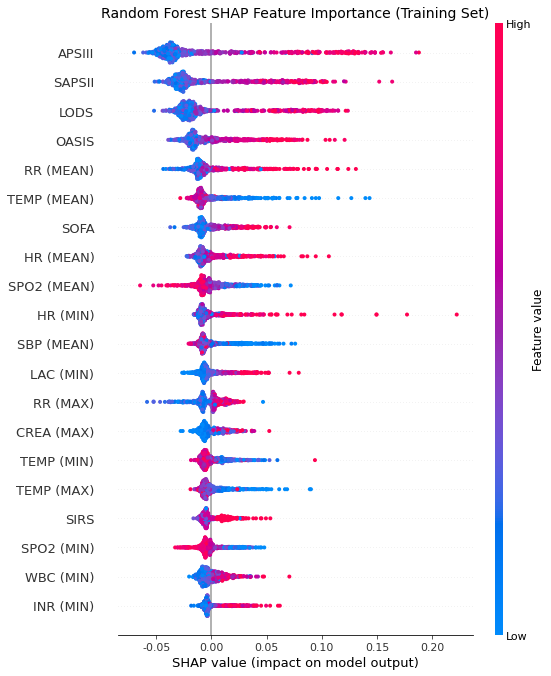

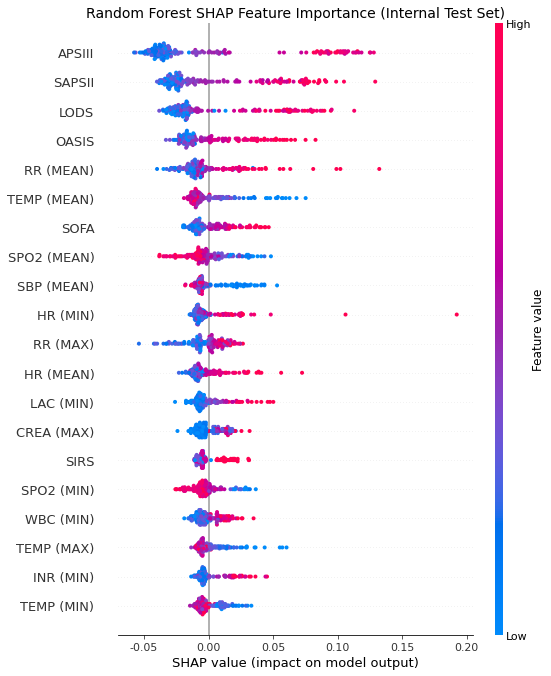

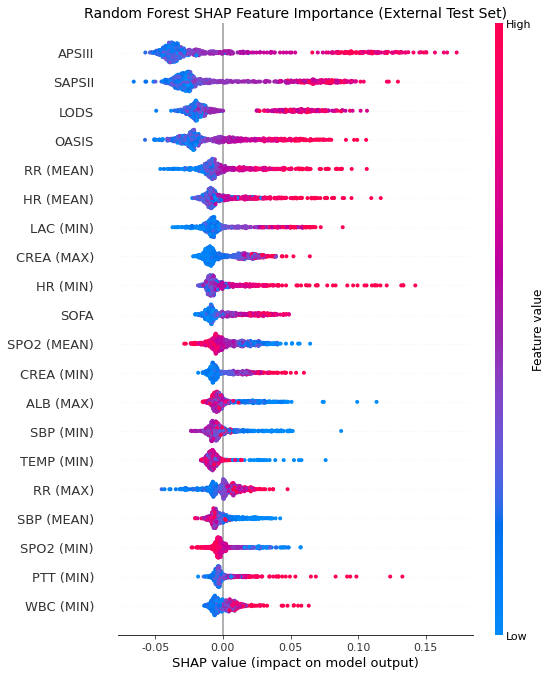

In [97]:
# 绘制汇总图 - 训练集
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_train, X_train, feature_names=feature_name, show=False)
plt.title("Random Forest SHAP Feature Importance (Training Set)", fontsize=14)
plt.tight_layout()
plt.savefig('shap_importance_training.png', dpi=300, bbox_inches='tight')
plt.show()

# 绘制汇总图 - 内部测试集
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_internal, X_internal_test, feature_names=feature_name, show=False)
plt.title("Random Forest SHAP Feature Importance (Internal Test Set)", fontsize=14)
plt.tight_layout()
plt.savefig('shap_importance_internal.png', dpi=300, bbox_inches='tight')
plt.show()

# 绘制汇总图 - 外部测试集
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_external, X_external, feature_names=feature_name, show=False)
plt.title("Random Forest SHAP Feature Importance (External Test Set)", fontsize=14)
plt.tight_layout()
plt.savefig('shap_importance_external.png', dpi=300, bbox_inches='tight')
plt.show()

In [104]:

# 计算平均绝对SHAP值作为特征重要性
shap_importance_train = pd.DataFrame({
    'Feature': feature_name,
    'Importance': np.abs(shap_values_train).mean(0)
}).sort_values('Importance', ascending=False)

shap_importance_internal = pd.DataFrame({
    'Feature': feature_name,
    'Importance': np.abs(shap_values_internal).mean(0)
}).sort_values('Importance', ascending=False)

shap_importance_external = pd.DataFrame({
    'Feature': feature_name,
    'Importance': np.abs(shap_values_external).mean(0)
}).sort_values('Importance', ascending=False)

# 保存到CSV文件
shap_importance_train.to_csv('shap_importance_train.csv', index=False)
shap_importance_internal.to_csv('shap_importance_internal.csv', index=False)
shap_importance_external.to_csv('shap_importance_external.csv', index=False)


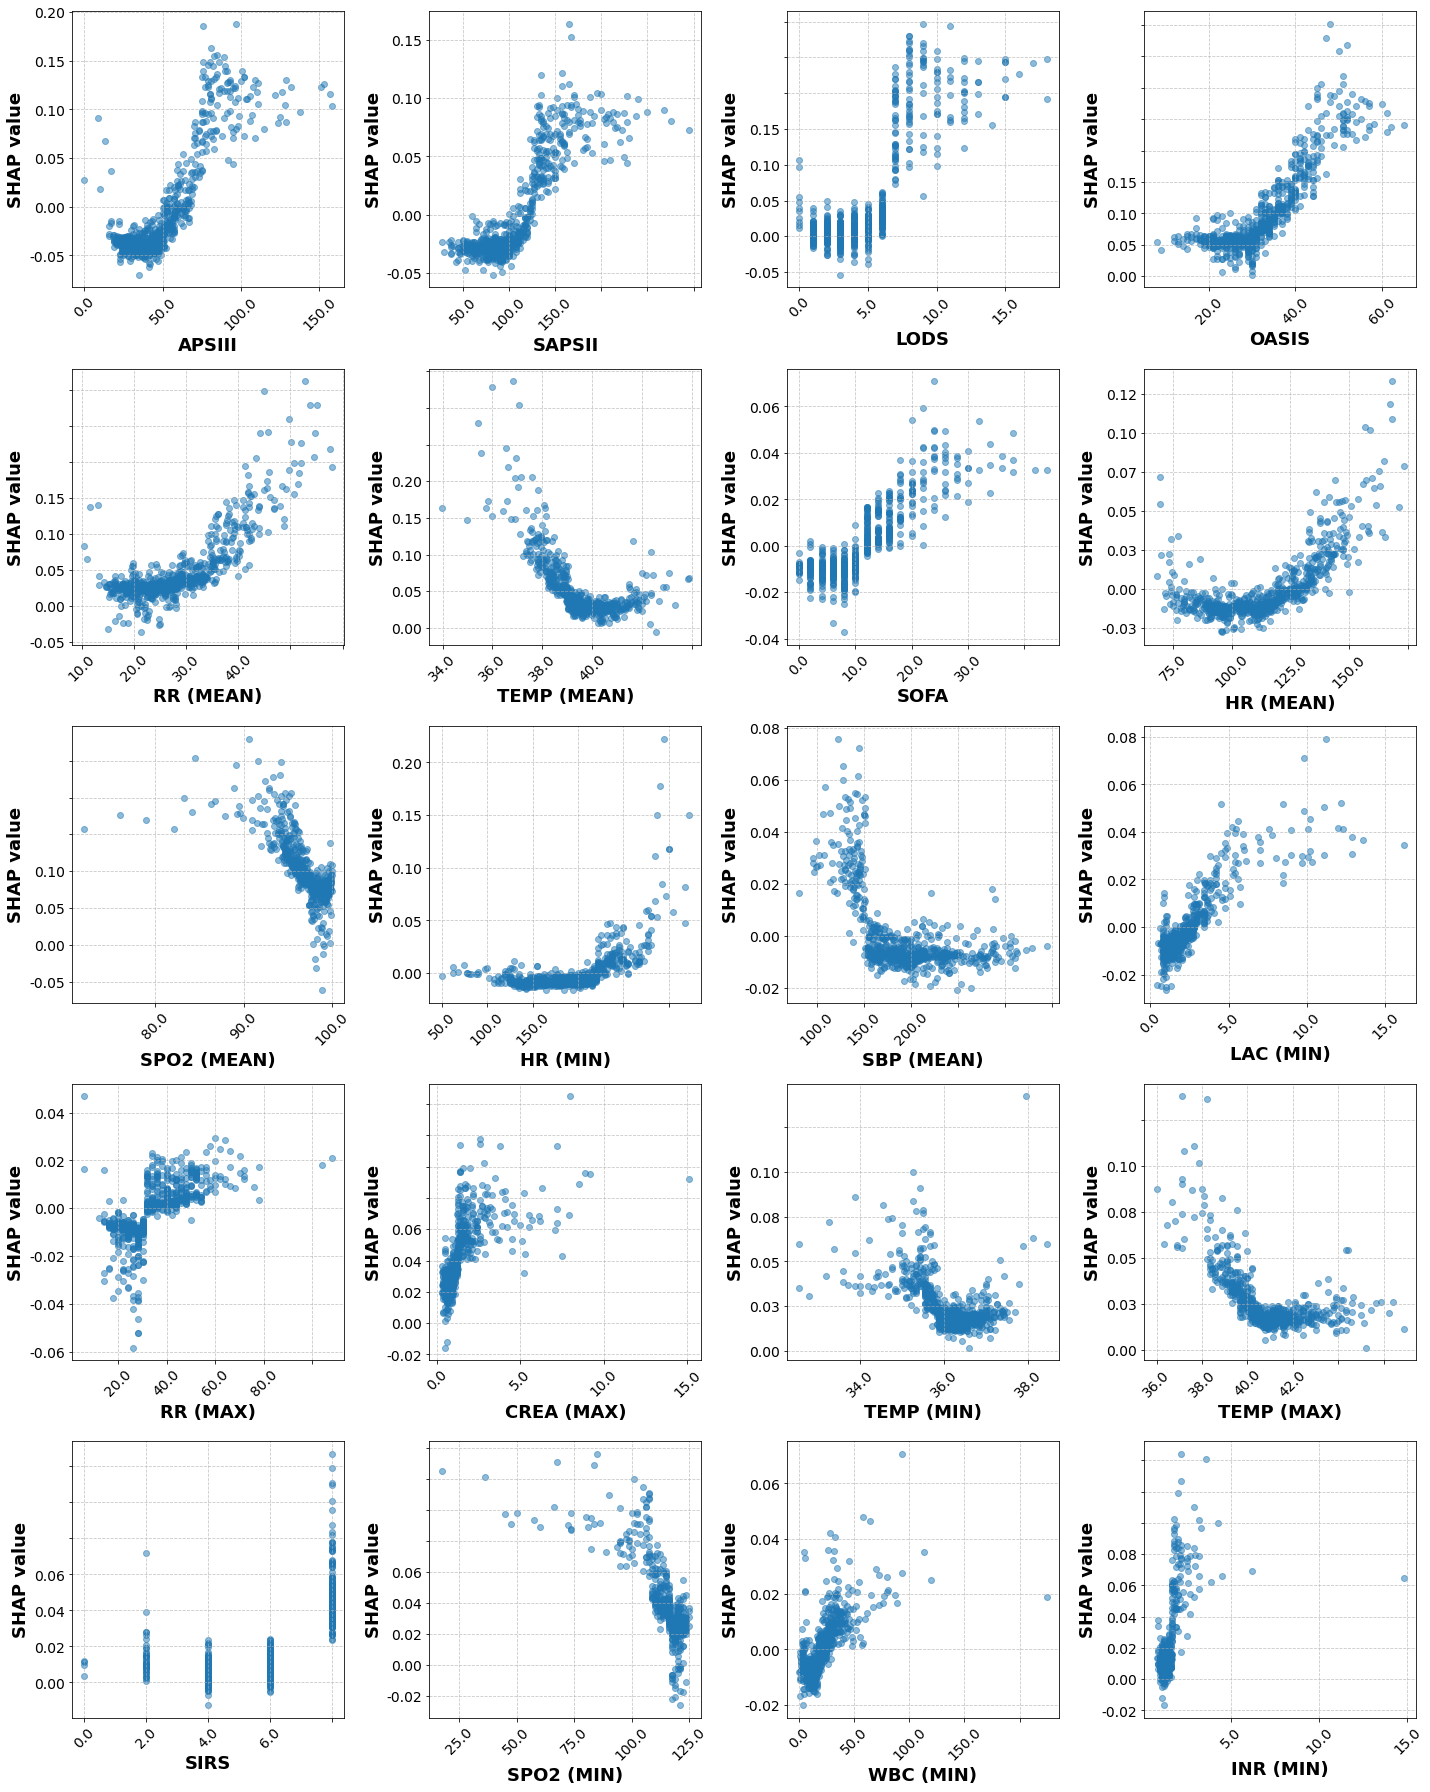

In [103]:

# 为前20个最重要的特征绘制SHAP依赖图
top_features = shap_importance_train['Feature'].head(20).tolist()

# 创建5*4的子图布局
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# 绘制每个特征的依赖图
for i in range(5):
    for j in range(4):
        idx = i * 4 + j
        if idx < len(top_features):
            feature = top_features[idx]
            feature_idx = list(feature_name).index(feature)
            
            ax = axes[i, j]
            
            # 计算该特征的SHAP值和特征值
            shap_values = shap_values_train[:, feature_idx]
            feature_values = X_train.iloc[:, feature_idx].values
            
            # 移除水平参考线，添加网格
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # 绘制散点图
            ax.scatter(feature_values, shap_values, alpha=0.5, color='#1f77b4')
            
            # 设置更大的标签字体大小
            ax.set_xlabel(feature, fontsize=18, fontweight='bold')
            ax.set_ylabel('SHAP value', fontsize=18, fontweight='bold')
            
            # 设置更大的刻度参数
            ax.tick_params(axis='both', labelsize=14)
            
            # 格式化刻度为一小数
            x_ticks = ax.get_xticks()
            y_ticks = ax.get_yticks()
            ax.set_xticklabels([f'{x:.1f}' for x in x_ticks], rotation=45)
            ax.set_yticklabels([f'{y:.2f}' for y in y_ticks])

plt.tight_layout()
plt.savefig('shap_dependency_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# ... existing code ...

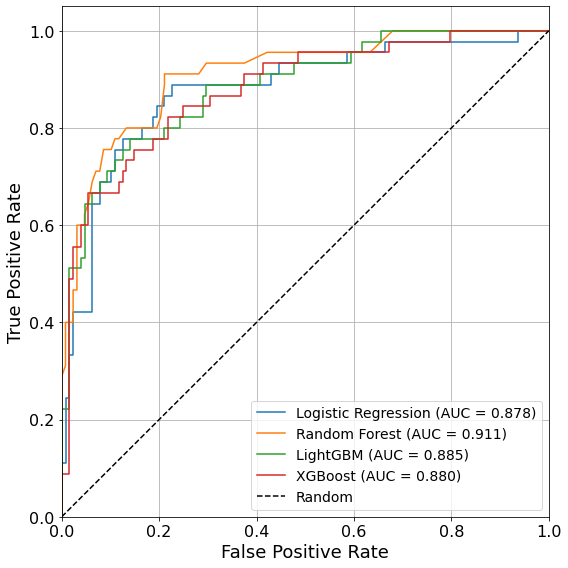

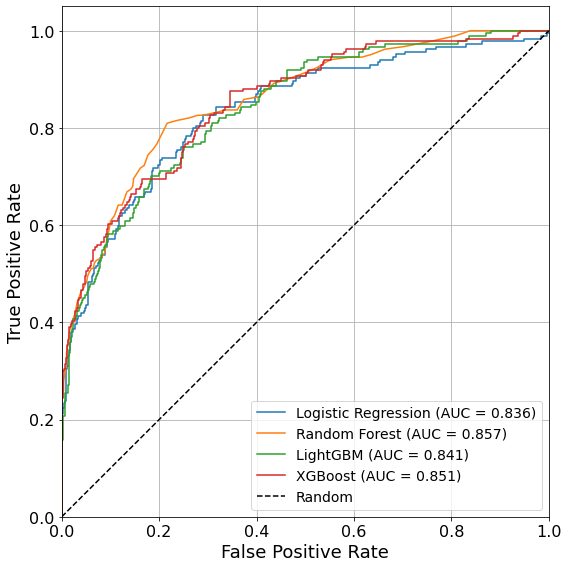

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 设置字体为Arial
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# 内部测试集的ROC曲线
plt.figure(figsize=(8, 8))
for name, model in internal_models.items():
    # 获取预测概率
    y_pred_proba = model.predict_proba(X_internal_test_scaled)[:, 1]
    # 计算ROC曲线
    fpr, tpr, _ = roc_curve(y_internal_test, y_pred_proba)
    # 计算AUC
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# 添加对角线
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.tick_params(axis='both', labelsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_internal.png', dpi=300, bbox_inches='tight')
plt.show()

# 外部测试集的ROC曲线
plt.figure(figsize=(8, 8))
for name, model in external_models.items():
    # 获取预测概率
    y_pred_proba = model.predict_proba(X_external_test_scaled)[:, 1]
    # 计算ROC曲线
    fpr, tpr, _ = roc_curve(y_external, y_pred_proba)
    # 计算AUC
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# 添加对角线
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.tick_params(axis='both', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_external.png', dpi=300, bbox_inches='tight')
plt.show()

In [101]:
# 获取所有样本的预测概率
# 创建一个新的DataFrame来存储预测概率
probas_df = pd.DataFrame()
probas_df['hospital_expire_flag'] = data['hospital_expire_flag']
probas_df['dataset'] = data['dataset']

# 对于MIMIC-III数据，使用内部验证模型预测
# 对于MIMIC-IV数据，使用外部验证模型预测
for name in models.keys():
    # 创建一个空列
    probas_df[f'{name}_proba'] = np.nan
    
    # 对MIMIC-III数据使用内部验证模型
    mimic3_probas = internal_models[name].predict_proba(scaler_internal.transform(X_mimic3))[:, 1]
    probas_df.loc[data['dataset'] == 'MIMIC-III', f'{name}_proba'] = mimic3_probas
    
    # 对MIMIC-IV数据使用外部验证模型
    mimic4_probas = external_models[name].predict_proba(scaler_external.transform(X_external))[:, 1]
    probas_df.loc[data['dataset'] == 'MIMIC-IV', f'{name}_proba'] = mimic4_probas

# 保存结果 - 只保存预测概率列
probas_df.to_csv('predictions_with_probas.csv', index=False)

# 显示添加了预测概率的前几行数据
print("\n添加预测概率后的数据预览：")
proba_cols = [col for col in probas_df.columns if col.endswith('_proba')]
print(probas_df[['hospital_expire_flag', 'dataset'] + proba_cols].head(10).round(3))

# 显示预测概率的基本统计信息
print("\n预测概率的统计描述：")
print(probas_df[proba_cols].describe().round(3))


添加预测概率后的数据预览：
   hospital_expire_flag    dataset  Logistic Regression_proba  \
0                     0  MIMIC-III                      0.184   
1                     1  MIMIC-III                      0.949   
2                     0  MIMIC-III                      0.032   
3                     1  MIMIC-III                      0.031   
4                     0  MIMIC-III                      0.117   
5                     0  MIMIC-III                      0.097   
6                     0  MIMIC-III                      0.387   
7                     0  MIMIC-III                      0.061   
8                     1  MIMIC-III                      0.790   
9                     0  MIMIC-III                      0.259   

   Random Forest_proba  LightGBM_proba  XGBoost_proba  
0                 0.06           0.000          0.001  
1                 0.76           0.913          0.885  
2                 0.12           0.096          0.056  
3                 0.65           0.974       

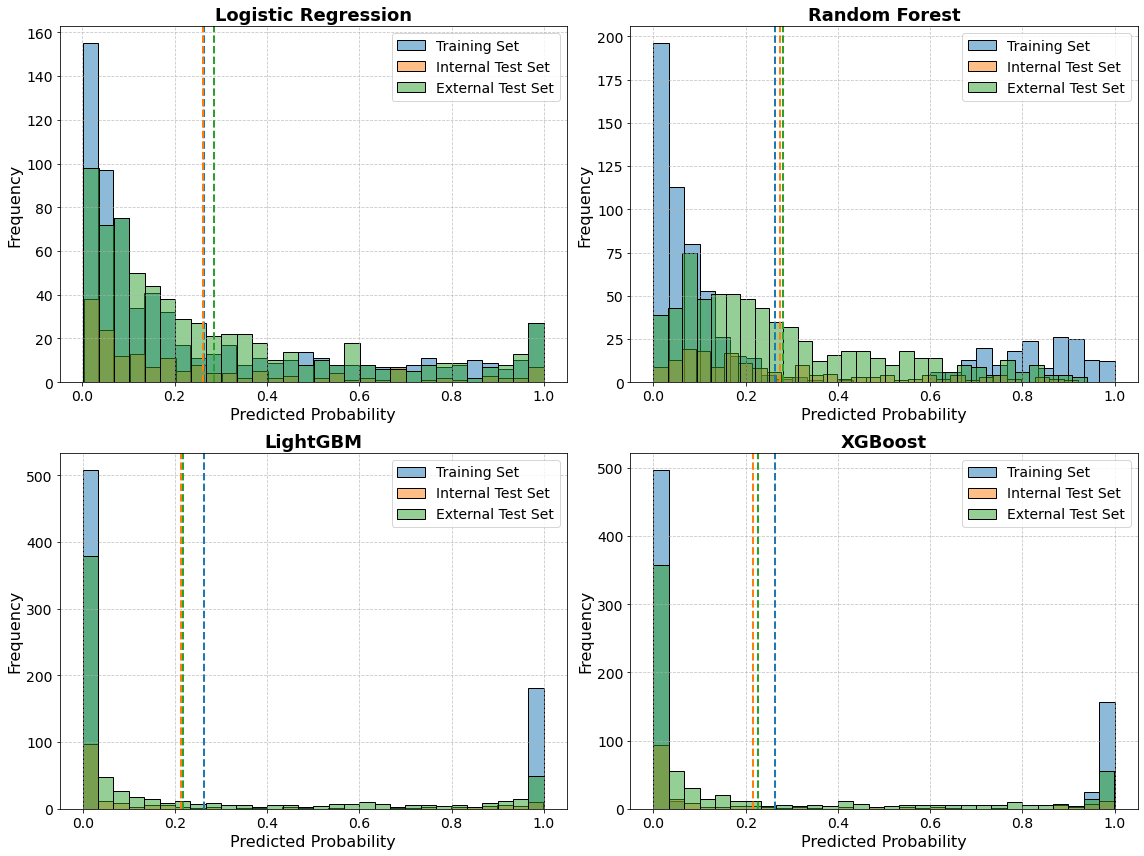

In [102]:
# 绘制每个模型预测概率的分布直方图
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体为Arial
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# 创建一个2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 模型名称和对应的颜色
model_colors = {
    'Logistic Regression': '#1f77b4',
    'Random Forest': '#ff7f0e',
    'LightGBM': '#2ca02c',
    'XGBoost': '#d62728'
}

# 为每个模型绘制直方图
for i, name in enumerate(models.keys()):
    ax = axes[i]
    
    # 获取预测概率
    y_train_proba = internal_models[name].predict_proba(X_train_scaled)[:, 1]
    y_internal_proba = internal_models[name].predict_proba(X_internal_test_scaled)[:, 1]
    y_external_proba = external_models[name].predict_proba(X_external_test_scaled)[:, 1]
    
    # 绘制直方图
    sns.histplot(y_train_proba, bins=30, alpha=0.5, label='Training Set', ax=ax, color='#1f77b4')
    sns.histplot(y_internal_proba, bins=30, alpha=0.5, label='Internal Test Set', ax=ax, color='#ff7f0e')
    sns.histplot(y_external_proba, bins=30, alpha=0.5, label='External Test Set', ax=ax, color='#2ca02c')
    
    # 添加垂直线表示平均预测概率
    ax.axvline(y_train_proba.mean(), color='#1f77b4', linestyle='--', linewidth=2)
    ax.axvline(y_internal_proba.mean(), color='#ff7f0e', linestyle='--', linewidth=2)
    ax.axvline(y_external_proba.mean(), color='#2ca02c', linestyle='--', linewidth=2)
    
    # 设置标题和标签
    ax.set_title(f'{name}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Predicted Probability', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    
    # 设置刻度标签字体大小
    ax.tick_params(axis='both', labelsize=14)
    
    # 添加图例
    ax.legend(fontsize=14)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()
plt.savefig('prediction_probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()